# Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks

## 0. Paper

### Info
* TItle : Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks
* Author : Jun-Yan Zhu et al.
* Link : https://arxiv.org/pdf/1703.10593.pdf

### Summary
* GAN을 활용한 image translation
* cycle consistency loss를 추가하여 이미지의 consistency 보장

### Features
* Dataset : horse2zebra, [link](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/)
* Epochs : 100 -> 10

## 1. Setting

In [ ]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

In [ ]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'batch_size' : 1,
}

## 2. Data

In [ ]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, directory, method):
        self.directory = directory
        self.method = method
        self.data = [os.path.join(self.directory, i) for i in os.listdir(self.directory)]
        self.on_epoch_end()
    
    def __len__(self):
        return np.ceil(len(self.data) / CONFIG['batch_size']).astype(np.int32)

    def on_epoch_end(self):
        self.idx = 0
        if self.method == 'test':
            self.indices = np.random.permutation(len(self.data))
        else:
            self.indices = np.arange(len(self.data))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[CONFIG['batch_size']*idx : CONFIG['batch_size']*(idx+1)]
        batch_x = [self.data[i] for i in batch_idx]
        batch_x = np.array([load_image(i) for i in batch_x])
        return batch_x
    
    def next(self):
        if self.idx == len(self) - 1:
            self.on_epoch_end()
        x = self.__getitem__(self.idx)
        self.idx += 1
        return x


def load_image(path, normalize=True):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if normalize:
        image = image.astype(np.float32)
        image = (image / 127.5) -1 # -1 ~ 1
    return image

def data_generator(train_loader_a, train_loader_b):
    while True:
        a = train_loader_a.next()
        b = train_loader_b.next()
        yield a, b

In [ ]:
# data_path = os.path.join(CONFIG['base_dir'], 'data/cezanne2photo.zip')
data_path = os.path.join(CONFIG['base_dir'], 'data/horse2zebra.zip')
!unzip $"{data_path}" -d '/content/data'

In [ ]:
example_a = load_image(os.path.join('data/trainA', os.listdir('data/trainA')[0]), normalize=False)
example_b = load_image(os.path.join('data/trainB', os.listdir('data/trainB')[0]), normalize=False)

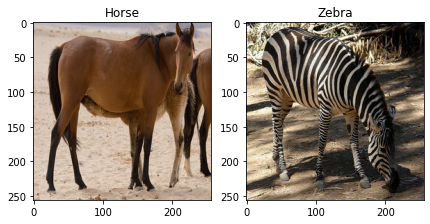

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 13))
ax[0].imshow(example_a)
ax[1].imshow(example_b)

ax[0].set_title('Horse')
ax[1].set_title('Zebra')
plt.show()

In [ ]:
train_loader_a = Dataloader('data/trainA', 'train')
train_loader_b = Dataloader('data/trainB', 'train')

In [ ]:
a = train_loader_a.next()
b = train_loader_b.next()
a.shape, b.shape

((1, 256, 256, 3), (1, 256, 256, 3))

## 3. Model

In [ ]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1)):
        super().__init__()
        self.padding_width = padding[0]
        self.padding_height = padding[1]
    
    def call(self, x):
        padding_tensor = [
            [0, 0],
            [self.padding_height, self.padding_height],
            [self.padding_width, self.padding_width],
            [0, 0]
            ]
        return tf.pad(x, padding_tensor, mode='REFLECT')

def residual_block(n_filters, inputs, method='add'):
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    x = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(inputs)
    x = tfa.layers.InstanceNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(inputs)
    x = tfa.layers.InstanceNormalization()(x)

    if method == 'add':
        outputs = tf.keras.layers.Add()([inputs, x])
    elif method == 'concat':
        outputs = tf.keras.layers.Concatenate()([inputs, x])
    return outputs

def build_discriminator(image_shape=(256, 256, 3), dim=64, num_layer=3):
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    inputs = tf.keras.layers.Input(shape=image_shape)
    x = tf.keras.layers.Conv2D(dim, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    for _ in range(num_layer):
        dim *= 2
        x = tf.keras.layers.Conv2D(dim, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
        x = tfa.layers.InstanceNormalization()(x)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    outputs = tf.keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(x)

    model = tf.keras.Model(inputs, outputs)
    return model

def build_generator(image_shape=(256, 256, 3), dim=64, num_conv=2, num_residual=9):
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    inputs = tf.keras.layers.Input(shape=image_shape)

    x = tf.keras.layers.Conv2D(64, (7,7), padding='same', kernel_initializer=init)(inputs)
    x = tfa.layers.InstanceNormalization()(x)    
    x = tf.keras.layers.Activation('relu')(x)

    for _ in range(num_conv):
        dim *= 2
        x = tf.keras.layers.Conv2D(dim, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(x)
        x = tfa.layers.InstanceNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

    for _ in range(num_residual):
        x = residual_block(dim, x)

    for _ in range(num_conv):
        dim /= 2
        x = tf.keras.layers.Conv2DTranspose(dim, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(x)
        x = tfa.layers.InstanceNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(3, (7,7), padding='same', kernel_initializer=init)(x)
    x = tfa.layers.InstanceNormalization()(x)
    outputs = tf.keras.layers.Activation('tanh')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
class Model(tf.keras.Model):
    def __init__(self, input_shape=(256, 256, 3), LAMBDA=10.0):
        super().__init__()
        self.LAMBDA = LAMBDA
        self.g_a = build_generator()
        self.g_b = build_generator()
        self.d_a = build_discriminator()
        self.d_b = build_discriminator()

    def compile(self):
        super().compile()
        self.opt_g_a = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
        self.opt_g_b = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
        self.opt_d_a = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
        self.opt_d_b = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
    
    def g_loss_fn(self, fake_prob):
        return tf.reduce_mean(tf.keras.losses.mse(tf.ones_like(fake_prob), fake_prob))
    
    def d_loss_fn(self, real_prob, fake_prob):
        real_loss = tf.keras.losses.mse(tf.ones_like(real_prob), real_prob)
        fake_loss = tf.keras.losses.mse(tf.zeros_like(fake_prob), fake_prob)
        loss = tf.reduce_mean(real_loss + fake_loss) * 0.5
        return loss
    
    def mae_loss_fn(self, real, fake):
        return tf.reduce_mean(tf.keras.losses.mae(real, fake))

    def call(self, x):
        pass

    def train_step(self, batch_data):
        real_a, real_b = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_a = self.g_a(real_b)
            fake_b = self.g_b(real_a)
            cycled_a = self.g_a(fake_b)
            cycled_b = self.g_b(fake_a)
            identity_a = self.g_a(real_a)
            identity_b = self.g_b(real_b)

            loss_adv_a = self.g_loss_fn(self.d_a(fake_a))
            loss_adv_b = self.g_loss_fn(self.d_b(fake_b))
            loss_cycle = self.mae_loss_fn(real_a, cycled_a) + self.mae_loss_fn(real_b, cycled_b)
            loss_identity_a = self.mae_loss_fn(real_a, identity_a)
            loss_identity_b = self.mae_loss_fn(real_b, identity_b)

            loss_g_a = loss_adv_a + self.LAMBDA * loss_cycle + self.LAMBDA * 0.5 * loss_identity_a
            loss_g_b = loss_adv_b + self.LAMBDA * loss_cycle + self.LAMBDA * 0.5 * loss_identity_b
            loss_d_a = self.d_loss_fn(self.d_a(real_a), self.d_a(fake_a))
            loss_d_b = self.d_loss_fn(self.d_b(real_b), self.d_b(fake_b))

        grad_g_a = tape.gradient(loss_g_a, self.g_a.trainable_variables)
        grad_g_b = tape.gradient(loss_g_b, self.g_b.trainable_variables)
        grad_d_a = tape.gradient(loss_d_a, self.d_a.trainable_variables)
        grad_d_b = tape.gradient(loss_d_b, self.d_b.trainable_variables)

        self.opt_g_a.apply_gradients(zip(grad_g_a, self.g_a.trainable_variables))
        self.opt_g_b.apply_gradients(zip(grad_g_b, self.g_b.trainable_variables))
        self.opt_d_a.apply_gradients(zip(grad_d_a, self.d_a.trainable_variables))
        self.opt_d_b.apply_gradients(zip(grad_d_b, self.d_b.trainable_variables))
        
        return {
            'Loss G A' : loss_g_a,
            'Loss G B' : loss_g_b,
            'Loss D A' : loss_d_a,
            'Loss D B' : loss_d_b
        }


def post_proc(img):
    img = img[0] * 127.5 + 127.5
    if type(img) == np.ndarray:
        return img.astype(np.int32)
    else:
        return img.numpy().astype(np.int32)
    return img

In [ ]:
model = Model()
model.compile()

## 4. Train

In [ ]:
class GANCallback(tf.keras.callbacks.Callback):
    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        fig, ax = plt.subplots(self.num_img, 2, figsize=(6, 6))
        for i in range(self.num_img):
            inputs = train_loader_a.next()
            translated = self.model.g_b(inputs)
            inputs = post_proc(inputs)
            translated = post_proc(translated)

            ax[i, 0].imshow(inputs)
            ax[i, 0].set_title("Input image")
            ax[i, 0].axis("off")

            ax[i, 1].imshow(translated)
            ax[i, 1].set_title("Translated image")
            ax[i, 1].axis("off")

        plt.show()
        plt.close()

In [ ]:
model.fit(
    data_generator(train_loader_a, train_loader_b),
    steps_per_epoch = 1000,
    epochs = 10,
    callbacks = [GANCallback()]
)

## 5. Test

In [ ]:
test_loader_a = Dataloader('data/testA', 'test')
test_loader_b = Dataloader('data/testB', 'test')

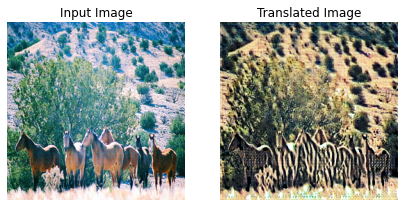

In [ ]:
inputs = test_loader_a.next()
translated = model.g_b(inputs)
inputs = post_proc(inputs)
translated = post_proc(translated)

fig, ax = plt.subplots(1, 2, figsize=(7, 13))
ax[0].imshow(inputs)
ax[0].set_title('Input Image')
ax[0].axis('off')

ax[1].imshow(translated)
ax[1].set_title('Translated Image')
ax[1].axis('off')

plt.show()